# Inverse Design Test

> example usecase for the ceviche gradients

In [1]:
%load_ext autoreload
%autoreload 2

## Preparation

In [2]:
import collections
import autograd.numpy as npa
import ceviche
import numpy as np
import matplotlib.pylab as plt
from ceviche import fdfd_ez, jacobian
from ceviche.modes import insert_mode
from jax.example_libraries.optimizers import adam
from tqdm.notebook import trange

Slice = collections.namedtuple('Slice', 'x y')

> This notebook was adapted from Ceviche's [inverse design introduction](https://github.com/fancompute/workshop-invdesign/blob/master/02_Invdes_intro.ipynb) to use a JAX-based optimization loop in stead of the default Ceviche optimization loop.

## Simulation and optimization parameters

Our toy optimization problem will be to design a device that converts an input in the first-order mode into an output as the second-order mode. First, we define the parameters of our device and optimization:

In [3]:
# Angular frequency of the source in Hz
omega = 2 * np.pi * 200e12
# Spatial resolution in meters
dl = 40e-9
# Number of pixels in x-direction
Nx = 100
# Number of pixels in y-direction
Ny = 100
# Number of pixels in the PMLs in each direction
Npml = 20
# Initial value of the structure's relative permittivity
epsr_init = 12.0
# Space between the PMLs and the design region (in pixels)
space = 10
# Width of the waveguide (in pixels)
wg_width = 12
# Length in pixels of the source/probe slices on each side of the center point
space_slice = 8
# Number of epochs in the optimization
Nsteps = 100
# Step size for the Adam optimizer
step_size = 1e-2

### Utility functions
We now define some utility functions for initialization and optimization:

In [4]:
def init_domain(
    Nx=Nx, Ny=Ny, Npml=Npml, space=space, wg_width=wg_width, space_slice=space_slice
):
    """Initializes the domain and design region

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """

    # Parametrization of the permittivity of the structure
    bg_epsr = np.ones((Nx, Ny))
    epsr = np.ones((Nx, Ny))

    # Region within which the permittivity is allowed to change
    design_region = np.zeros((Nx, Ny))

    # Input waveguide
    bg_epsr[0 : int(Npml + space), int(Ny / 2 - wg_width / 2) : int(Ny / 2 + wg_width / 2)] = epsr_init

    # Input probe slice
    input_slice = Slice(
        x=np.array(Npml + 1),
        y=np.arange(
            int(Ny / 2 - wg_width / 2 - space_slice),
            int(Ny / 2 + wg_width / 2 + space_slice),
        ),
    )

    # Output waveguide
    bg_epsr[
        int(Nx - Npml - space) : :,
        int(Ny / 2 - wg_width / 2) : int(Ny / 2 + wg_width / 2),
    ] = epsr_init

    # Output probe slice
    output_slice = Slice(
        x=np.array(Nx - Npml - 1),
        y=np.arange(
            int(Ny / 2 - wg_width / 2 - space_slice),
            int(Ny / 2 + wg_width / 2 + space_slice),
        ),
    )

    design_region[Npml + space: Nx - Npml - space, Npml + space: Ny - Npml - space] = 1.0
    epsr[Npml + space : Nx - Npml - space, Npml + space : Ny - Npml - space] = epsr_init

    return epsr, bg_epsr, design_region, input_slice, output_slice

In [5]:
def mask_combine_epsr(epsr, bg_epsr, design_region):
    """Utility function for combining the design region epsr and the background epsr"""
    return epsr * design_region + bg_epsr * np.asarray(design_region == 0, dtype=float)

In [11]:
#| hide
import numpy as np
import matplotlib.pylab as plt

""" 
Utilities for plotting and visualization directly copied from the upstream version of ceviche. 
Can be replaced as soon as the new version of ceviche is released"""

def plot_real(val, outline=None, ax=None, cbar=False, cmap='RdBu', outline_alpha=0.5):
    """Plots the real part of 'val', optionally overlaying an outline of 'outline'
    """

    if ax is None:
        fig, ax = plt.subplots(1, 1, constrained_layout=True)
    
    vmax = np.abs(val).max()
    h = ax.imshow(np.real(val.T), cmap=cmap, origin='lower', vmin=-vmax, vmax=vmax)
    
    if outline is not None:
        ax.contour(outline.T, 0, colors='k', alpha=outline_alpha)
    
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    if cbar:
        plt.colorbar(h, ax=ax)
    
    return ax

def plot_abs(val, outline=None, ax=None, cbar=False, cmap='magma', outline_alpha=0.5, outline_val=None):
    """Plots the absolute value of 'val', optionally overlaying an outline of 'outline'
    """
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, constrained_layout=True)      
    
    vmax = np.abs(val).max()
    h = ax.imshow(np.abs(val.T), cmap=cmap, origin='lower', vmin=0, vmax=vmax)
    
    if outline_val is None and outline is not None: outline_val = 0.5*(outline.min()+outline.max())
    if outline is not None:
        ax.contour(outline.T, [outline_val], colors='w', alpha=outline_alpha)
    
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    if cbar:
        plt.colorbar(h, ax=ax)
    
    return ax

In [6]:
def viz_sim(epsr, source, slices=[]):
    """Solve and visualize a simulation with permittivity 'epsr'"""
    simulation = fdfd_ez(omega, dl, epsr, [Npml, Npml])
    _, _, Ez = simulation.solve(source)
    _, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3))
    plot_real(Ez, outline=epsr, ax=ax[0], cbar=False)
    for sl in slices:
        ax[0].plot(sl.x * np.ones(len(sl.y)), sl.y, "b-")
    plot_abs(epsr, ax=ax[1], cmap="Greys")
    plt.show()
    return (simulation, ax)

In [7]:
def mode_overlap(E1, E2):
    """Defines an overlap integral between the simulated field and desired field"""
    return npa.abs(npa.sum(npa.conj(E1) * E2))

### Visualizing the starting device

We can visualize what our starting device looks like and how it behaves. Our device is initialized by the `init_domain()` function which was defined several cells above.

In [8]:
# Initialize the parametrization rho and the design region
epsr, bg_epsr, design_region, input_slice, output_slice = init_domain(
    Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice
)

epsr_total = mask_combine_epsr(epsr, bg_epsr, design_region)

# Setup source
source = insert_mode(omega, dl, input_slice.x, input_slice.y, epsr_total, m=1)

# Setup probe
probe = insert_mode(omega, dl, output_slice.x, output_slice.y, epsr_total, m=2)

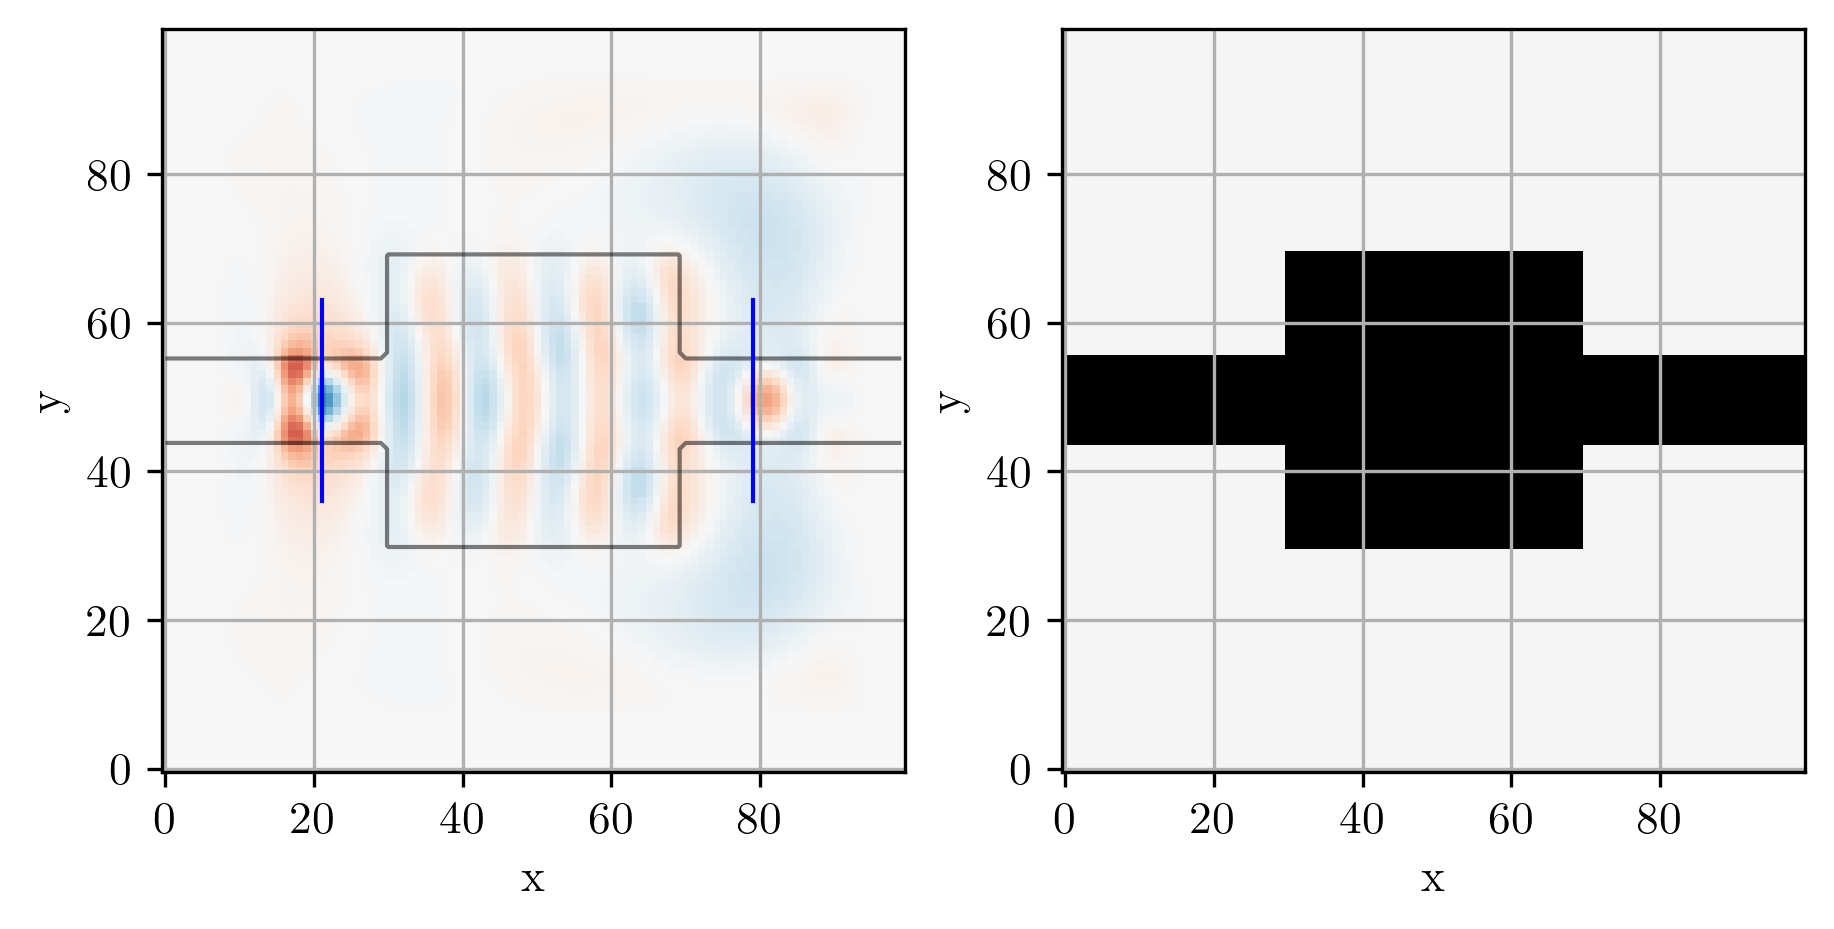

In [9]:
# Simulate initial device
simulation, ax = viz_sim(epsr_total, source, slices=[input_slice, output_slice])

# get normalization factor (field overlap before optimizing)
_, _, Ez = simulation.solve(source)
E0 = mode_overlap(Ez, probe)

### Define objective function

We will now define our objective function. This is a scalar-valued function which our optimizer uses to improve the device's performance.

Our objective function will consist of maximizing an overlap integral of the field in the output waveguide of the simulated device and the field of the waveguide's second order mode (minimizing the negative overlap). The function takes in a single argument, `epsr` and returns the value of the overlap integral. The details of setting the permittivity and solving for the fields happens inside the objective function.

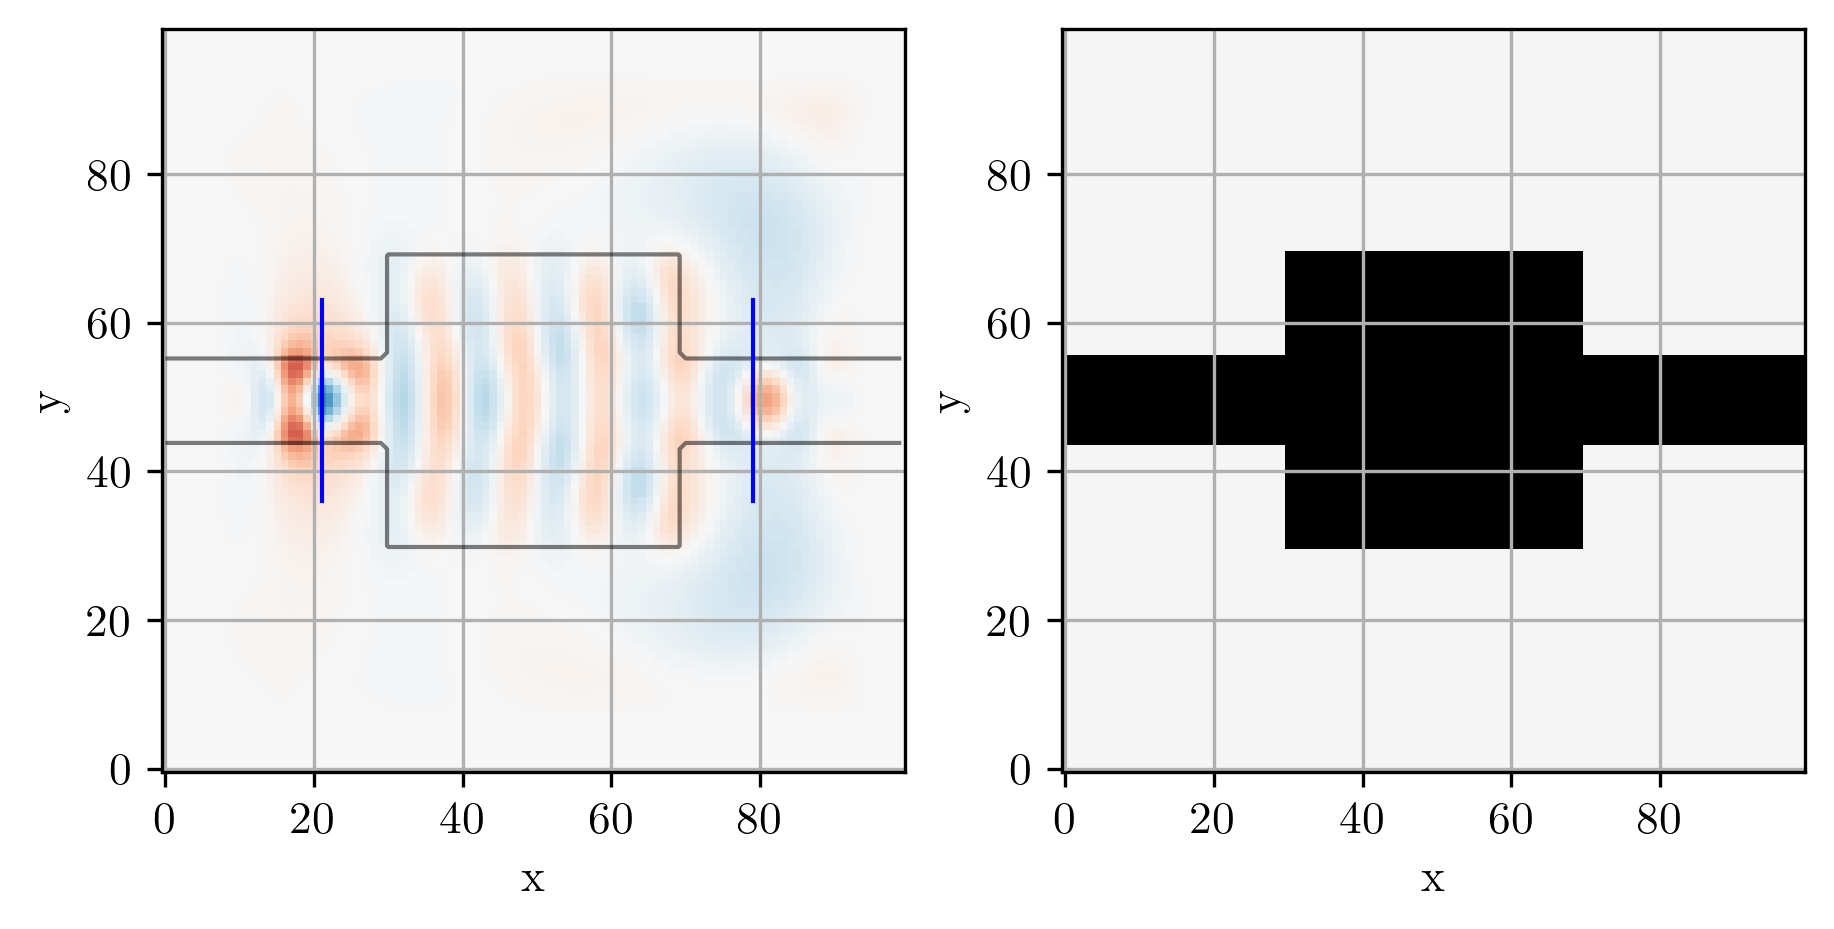

In [ ]:
# Simulate initial device
simulation, ax = viz_sim(epsr_total, source, slices=[input_slice, output_slice])

## Jaxit

In [ ]:
from javiche import jaxit
import jax

In [ ]:
@jaxit()
def loss_fn(epsr, lossfactor):
    """Objective function called by optimizer
    
    1) Takes the epsr distribution as input
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """
    #epsr = epsr.reshape((Nx, Ny))
    simulation.eps_r = mask_combine_epsr(epsr, bg_epsr, design_region)
    _, _, Ez = simulation.solve(source)
    return -mode_overlap(Ez, probe) / E0 * lossfactor

The `@jaxit()` decorator enables the automatic differntiation with the decorated function while internally calculating the gradients using `ceviche`s `jacobian` which is based on autograd.

In [ ]:
grad_fn = jax.grad(loss_fn)

With the decorator in place we can 

In [ ]:
grad_fn(epsr, 2.0)

Array([[-0.,  0.,  0., ..., -0., -0.,  0.],
       [-0., -0., -0., ...,  0.,  0., -0.],
       [-0., -0., -0., ...,  0., -0., -0.],
       ...,
       [ 0., -0., -0., ..., -0., -0., -0.],
       [-0., -0.,  0., ..., -0., -0., -0.],
       [-0.,  0.,  0., ..., -0., -0., -0.]], dtype=float32)

In [ ]:
init_fn, update_fn, params_fn = adam(step_size)
state = init_fn(epsr)
lossfactor = 2

In [ ]:
def step_fn(step, state):
    #latent = np.asarray(params_fn(state), dtype=float) # we need autograd arrays here...
    latent = params_fn(state) # we need autograd arrays here...
    loss = loss_fn(latent, lossfactor)
    grads = grad_fn(latent, lossfactor)
    optim_state = update_fn(step, grads, state)
    return loss, optim_state

In [ ]:
range_ = trange(10)
for step in range_:
    loss, state = step_fn(step, state)
    range_.set_postfix(loss=float(loss))

  0%|          | 0/10 [00:00<?, ?it/s]